<a href="https://colab.research.google.com/github/Gooogr/Book_nlp_with_transformers/blob/main/ch2_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Example of sentiment analysis. <br>
Cover:
* Hugging face (HF) Datasets (load and process datasets)
* HF Tokenizers (tokenize input text)
* HF Transformers (load, train and infer models)
* HF Datasets (load metrics and model evaluation)

In [ ]:
!pip install -qq transformers[sentencepiece] datasets

In [107]:
import datasets
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import torch

### Download data

In [5]:
all_datasets_names = datasets.list_datasets()
print(f'Total amount of datasets: {len(all_datasets_names)}')
print(f'The first 5 are: {all_datasets_names[:5]}')

Total amount of datasets: 4828
The first 5 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus']


In [6]:
emotion = datasets.load_dataset('emotion')

Using custom data configuration default


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
emotion

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [9]:
emotion['train'][:5] #note to apache arraw format. We got lists, not individual elements!

{'label': [0, 0, 3, 2, 3],
 'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy']}

### EDA

In [15]:
emotion.set_format(type='pandas') # to simplify EDA part

In [19]:
df = emotion['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [20]:
def label_int2str(x):
    '''
    Decode label index to str category. Use int2str method.
    '''
    return emotion['train'].features['label'].int2str(x)

In [21]:
df['label_name'] = df['label'].apply(label_int2str)

In [22]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


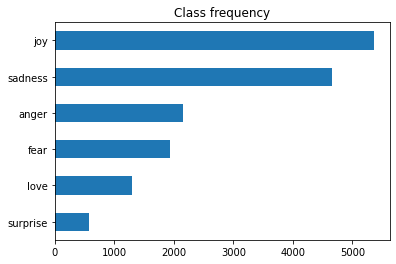

In [38]:
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('Class frequency')
plt.show()

Dataset in imbalanced. But for simplification we will skip any upsepmling/downsampling steps.

In [44]:
df['words_per_tweet'] = df['text'].str.split().apply(lambda x: len(x))

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


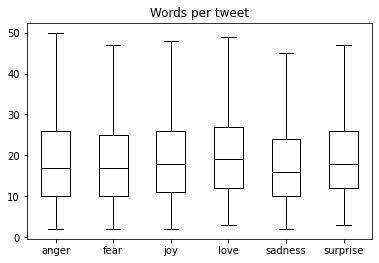

In [75]:
df.boxplot(column="words_per_tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.title('Words per tweet')
plt.xlabel("")
plt.show()

In general tweets have similar length. Mode value is 15.

In [78]:
emotion.reset_format()

### Tokenization

We will use WordPiece wich is part of BERT and DistilBERT pipelines.

In [80]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [88]:
example_text = "Tokenizing text is a core task of NLP"

# encode
encoded_text = tokenizer(example_text)
print(encoded_text)

# convert to tokens
tokens = tokenizer.convert_ids_to_tokens(encoded_text['input_ids'])
print(tokens)

# convert to string
string = tokenizer.convert_tokens_to_string(tokens)
print(string)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '[SEP]']
[CLS] tokenizing text is a core task of nlp [SEP]


Ok, time to tokenize our dataset

In [92]:
#emotion['train']['text']

In [93]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [99]:
tokenize(emotion['train'][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

First tweet is shorter the the second, the it was padded by zeros to make equal length. Attantion mask hided these additional zeroes.

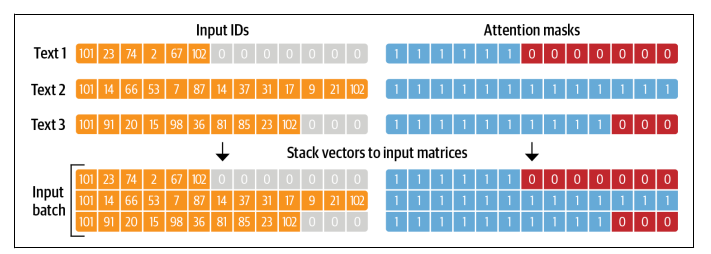

Apply tokenizer to our dataset

In [102]:
emotion_encoded = emotion.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [104]:
emotion_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

### Classifier training

#### Option 1: Feature extraction without fine-tuning

In [108]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)
print('device in use:', device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


device in use: cuda
